# Predictive modeling to understand customer purchasing behaviors

# Jennifer Brosnahan, MPH

### Import libraries

In [1]:
# DS Basics
import numpy as np
import pandas as pd
import sys
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Stuff
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Helpers
%matplotlib inline

In [218]:
# Visualizing Trees
import six
from six import StringIO
from IPython.display import Image
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus

In [3]:
# Experimentation
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from feature_engine.discretisers import DecisionTreeDiscretiser

### Read data set using pandas

In [4]:
data = pd.read_excel(r'C:\Users\jlbro\Desktop\Demographic_Data.xlsx')

In [5]:
data.head()

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


In [6]:
data.describe()

,in-store,age,items,amount,region
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.500000,45.757925,4.504975,835.919670,2.675000
std,0.500003,15.715679,2.061238,721.273736,1.126672
min,0.000000,18.000000,1.000000,5.004700,1.000000
25%,0.000000,33.000000,3.000000,285.140000,2.000000
50%,0.500000,45.000000,4.000000,582.315000,3.000000
75%,1.000000,56.000000,6.000000,1233.700000,4.000000
max,1.000000,85.000000,8.000000,3000.000000,4.000000


In [7]:
# Cleaning the data
data = data.drop_duplicates()

In [8]:
# Descriptive statistics
data.describe()

,in-store,age,items,amount,region
count,79979.000000,79979.000000,79979.000000,79979.000000,79979.000000
mean,0.500006,45.758512,4.505133,835.825727,2.674915
std,0.500003,15.715158,2.061250,721.263650,1.126642
min,0.000000,18.000000,1.000000,5.004700,1.000000
25%,0.000000,33.000000,3.000000,285.120000,2.000000
50%,1.000000,45.000000,4.000000,582.140000,3.000000
75%,1.000000,56.000000,6.000000,1233.400000,4.000000
max,1.000000,85.000000,8.000000,3000.000000,4.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79979 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   in-store  79979 non-null  int64  
 1   age       79979 non-null  int64  
 2   items     79979 non-null  int64  
 3   amount    79979 non-null  float64
 4   region    79979 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.7 MB


### EDA with pandas-profiling

In [10]:
import pandas_profiling
from pandas_profiling import ProfileReport

pandas_profiling.ProfileReport(data)

### Create new categorized columns for age and amount for future model adjustment
### We will try discretizing by equal size and equal widths

In [67]:
# Discretizing age by equal size bins
pd.qcut(data['age'], q=4)

0          (33.0, 45.0]
1          (33.0, 45.0]
2          (33.0, 45.0]
3          (45.0, 56.0]
4        (17.999, 33.0]
              ...      
79995      (56.0, 85.0]
79996      (56.0, 85.0]
79997      (45.0, 56.0]
79998      (45.0, 56.0]
79999    (17.999, 33.0]
Name: age, Length: 79979, dtype: category
Categories (4, interval[float64]): [(17.999, 33.0] < (33.0, 45.0] < (45.0, 56.0] < (56.0, 85.0]]

In [68]:
# Defining equal-sized age category
data['age_cat_4'] = pd.qcut(data['age'], q=4)

In [69]:
le = LabelEncoder()
le.fit(data['age_cat_4'])

le.classes_

array([Interval(17.999, 33.0, closed='right'),
       Interval(33.0, 45.0, closed='right'),
       Interval(45.0, 56.0, closed='right'),
       Interval(56.0, 85.0, closed='right')], dtype=object)

In [70]:
# Turning age_cat_4 into numeric value
data['age_cat_4'] = le.transform(data['age_cat_4'])

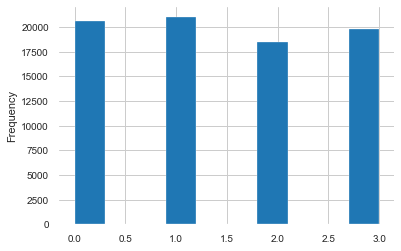

In [71]:
# Histogram of 4 equal size bins for age
data['age_cat_4'].plot(kind='hist')

In [107]:
# Defining equal-sized age category
data['age_cat_5'] = pd.qcut(data['age'], q=5)

In [108]:
le = LabelEncoder()
le.fit(data['age_cat_5'])

le.classes_

array([Interval(17.999, 31.0, closed='right'),
       Interval(31.0, 40.0, closed='right'),
       Interval(40.0, 49.0, closed='right'),
       Interval(49.0, 60.0, closed='right'),
       Interval(60.0, 85.0, closed='right')], dtype=object)

In [109]:
# Turning age_cat_4 into numeric value
data['age_cat_5'] = le.transform(data['age_cat_5'])

In [60]:
# Now discretizing age by equal width bins
# Experimented with various bins, 10 came out best
data['age_cat'] = pd.cut(data.age, bins=10)

le = LabelEncoder()
le.fit(data['age_cat'])

le.classes_

array([Interval(17.933, 24.7, closed='right'),
       Interval(24.7, 31.4, closed='right'),
       Interval(31.4, 38.1, closed='right'),
       Interval(38.1, 44.8, closed='right'),
       Interval(44.8, 51.5, closed='right'),
       Interval(51.5, 58.2, closed='right'),
       Interval(58.2, 64.9, closed='right'),
       Interval(64.9, 71.6, closed='right'),
       Interval(71.6, 78.3, closed='right'),
       Interval(78.3, 85.0, closed='right')], dtype=object)

In [61]:
data['age_cat'] = le.transform(data['age_cat'])

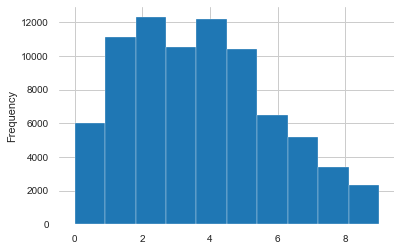

In [62]:
# Histogram of 10 equal width bins for age
data['age_cat'].plot(kind='hist')

In [63]:
# Discretizing amount by equal sized bins for predictive modeling
data['amount_cat'] = pd.qcut(data['amount'], q=4)

le.fit(data['amount_cat'])
le.classes_

array([Interval(5.004, 285.12, closed='right'),
       Interval(285.12, 582.14, closed='right'),
       Interval(582.14, 1233.4, closed='right'),
       Interval(1233.4, 3000.0, closed='right')], dtype=object)

In [64]:
data['amount_cat'] = le.transform(data['amount_cat'])

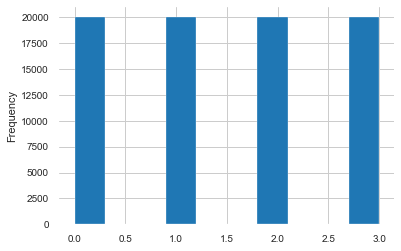

In [65]:
# Histogram of 10 equal width bins for Amount
data['amount_cat'].plot(kind='hist')

### Most comprehensive dataset now includes discrete age and amount columns

In [72]:
data.head()

,items,in-store,amount,age,region,age_cat,amount_cat,age_cat_4
0,4,0,281.03,37,2,2,0,1
1,2,0,219.51,35,2,2,0,1
2,3,1,1525.70,45,4,4,3,1
3,3,1,715.25,46,3,4,2,2
4,4,1,1937.50,33,1,2,3,0


### Are there differences in the age of customers between regions?

In [26]:
# Average age by region
data.groupby('region')['age'].mean()

region
1    43.704132
2    56.609083
3    45.646944
4    38.752424
Name: age, dtype: float64

The above chart reveals there is an age difference between regions. Region 2 is oldest, followed by regions 3, 1, and 4. Average age of region 2 is 18 years older than region 4

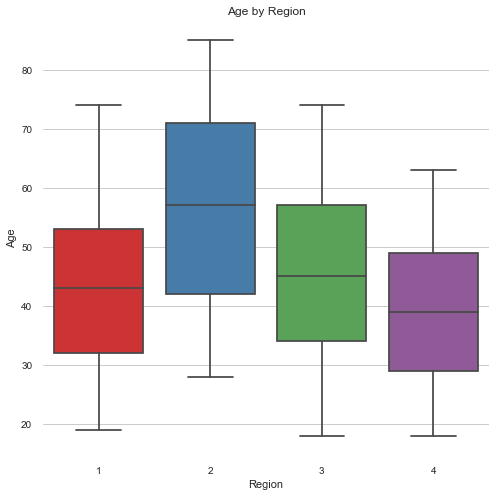

In [27]:
# Visualizing average age by region
sns.set_style('whitegrid') 
plt.figure(figsize=(8,8)) # Reset figure size proportionally
h = sns.boxplot(x='region', y='age', data=data, palette='Set1')
plt.xlabel('Region')
plt.ylabel('Age')
plt.title('Age by Region')
plt.show(h)

In [28]:
data = data[['items', 'in-store', 'amount', 'age', 'region']]
data.head()

,items,in-store,amount,age,region
0,4,0,281.03,37,2
1,2,0,219.51,35,2
2,3,1,1525.70,45,4
3,3,1,715.25,46,3
4,4,1,1937.50,33,1


# Building a model to predict region of purchase based on other demographic variables

In [29]:
# Features
X = data.iloc[:,0:4]
print('Summary of feature sample')
X.head()

Summary of feature sample


,items,in-store,amount,age
0,4,0,281.03,37
1,2,0,219.51,35
2,3,1,1525.70,45
3,3,1,715.25,46
4,4,1,1937.50,33


In [30]:
# Dependent variable
y = data.iloc[:,4]
y.head()

0    2
1    2
2    4
3    3
4    1
Name: region, dtype: int64

In [31]:
# Preparing two classification algorithms
algos_Class = []
algos_Class.append(('Random Forest Classifier',
                   RandomForestClassifier()))
algos_Class.append(('Decision Tree Classifier',
                    DecisionTreeClassifier()))

In [32]:
# Classification
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    names.append(name)
    results.append(result)

In [33]:
# Determining optimal algorithm using cross val score (lower is better)
for i in range(len(names)):
    print(names[i], results[i].mean())

Random Forest Classifier 0.5832030530295906
Decision Tree Classifier 0.5638605118613195


In [34]:
# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [35]:
# Modeling (Classification)
algo = DecisionTreeClassifier(random_state = 123)

In [36]:
all_accuracies = cross_val_score(estimator=algo, X=X_train, y=y_train, cv=5)
print(all_accuracies)

[0.5634742  0.5654747  0.56355756 0.56322414 0.56435478]


In [37]:
print(all_accuracies.std())

0.0008213817978555571


In [38]:
from pprint import pprint

In [39]:
# Parameters currently in use
pprint(algo.get_params())

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 123,
 'splitter': 'best'}


In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
param_grid = {
    'max_depth': [4, 8, 16],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4]
}

In [42]:
CV_algo = GridSearchCV(estimator=algo, param_grid=param_grid, cv=5)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=123,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [43]:
# Grid Search CV reveals best parameters to use for tuning model
CV_algo.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

In [44]:
# Modeling (Classification), tuning hyperparameters
algo = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 4,
    max_features = 4)
model = algo.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [45]:
# Predictions
preds = model.predict(X_test)
print('Accuracy for Decision Tree on CV data: '), accuracy_score(y_test, preds)

Accuracy for Decision Tree on CV data: 


(None, 0.6410102525631408)

In [46]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.40      0.54      0.46      4036
           2       0.90      1.00      0.95      4982
           3       0.54      0.22      0.32      4524
           4       0.65      0.72      0.68      6453

    accuracy                           0.64     19995
   macro avg       0.62      0.62      0.60     19995
weighted avg       0.64      0.64      0.62     19995



In [47]:
# List specifying region classes
region_values = ['1','2','3','4']

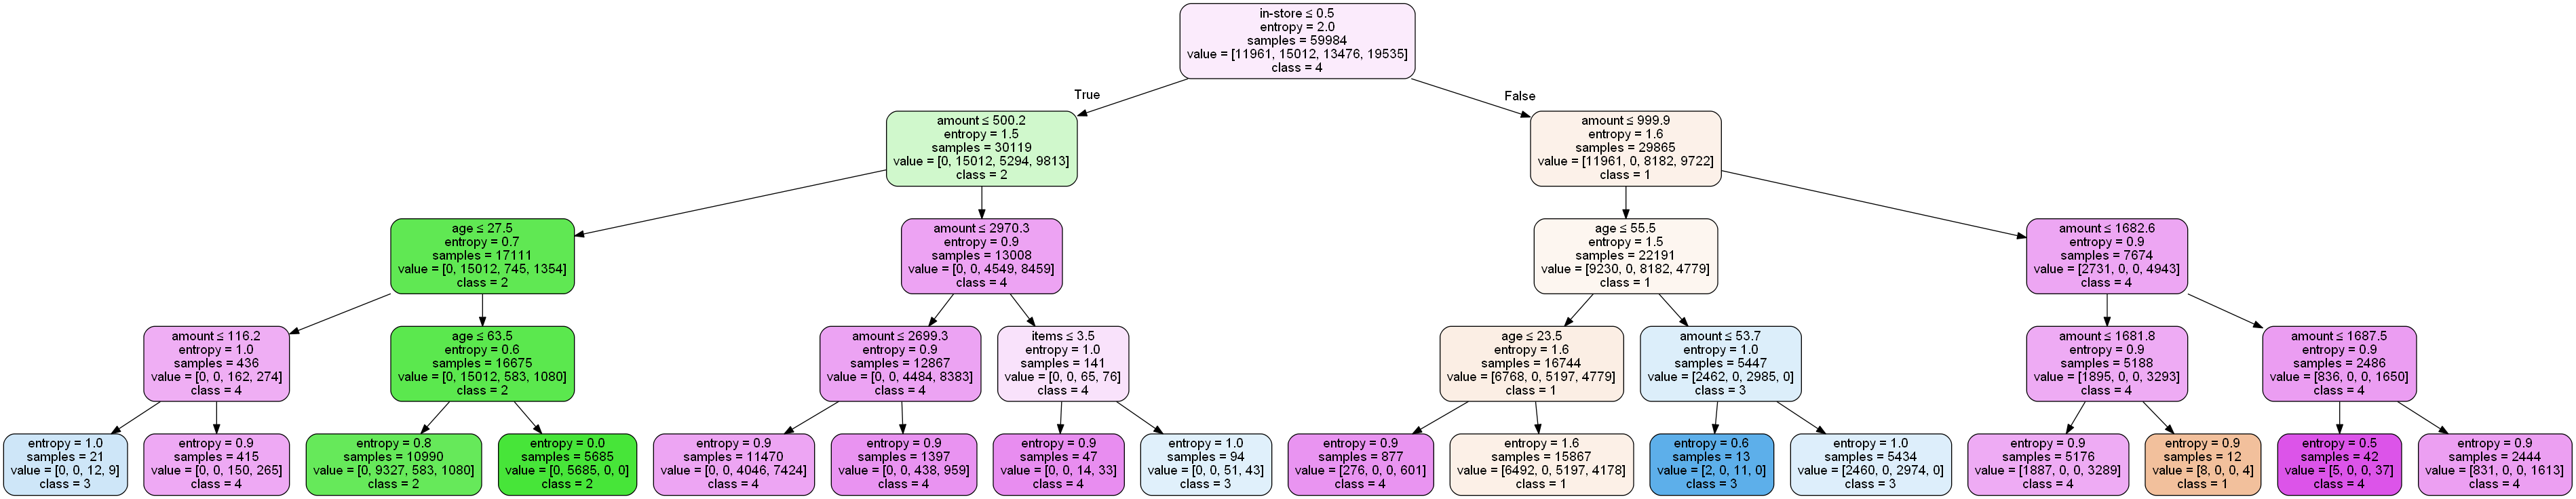

In [48]:
# Visualizing Decision Tree Model
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
    filled=True, rounded=True,
    feature_names=X.columns,
    class_names=region_values, label='all', precision=1,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

# Using Model 1 to make predictions with 64% accuracy
### Feature order = items, in-store, amount, age

In [49]:
# With 64% accuracy, we can say 24 yr old customer who spends $500 purchasing 6 items online will be from region 4
model.predict([[6, 0, 500, 24]])

array([4], dtype=int64)

In [50]:
# 45 year old customer who spends $200 purchasing 2 items in-store, with 64% accuracy, will be from region 1
model.predict([[2, 1, 200, 45]])

array([1], dtype=int64)

In [51]:
# 78 year old customer spending $800 in-store buying 4 items may be from region 3
model.predict([[4, 1, 800, 78]])

array([3], dtype=int64)

# Model 2 will use feature selection to try to improve accuracy

In [52]:
# Model 2 will remove 'items' as a feature due to having no correlation with other variables
# Features
X = data[['in-store','age','amount']]
print('Summary of feature sample')
X.head()

Summary of feature sample


,in-store,age,amount
0,0,37,281.03
1,0,35,219.51
2,1,45,1525.70
3,1,46,715.25
4,1,33,1937.50


In [53]:
# dependent variable
y = data[['region']]
y.head()

,region
0,2
1,2
2,4
3,3
4,1


In [54]:
# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [55]:
# Modeling (Classification), tuning hyperparameters
algo = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 4,
    max_features=3)
model = algo.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [56]:
all_accuracies = cross_val_score(estimator=algo, X=X_train, y=y_train, cv=5)
print(all_accuracies)

[0.64432775 0.64524464 0.64957906 0.64082687 0.64696566]


In [57]:
# Predictions
preds = model.predict(X_test)
print('Accuracy for Decision Tree on CV data: '), accuracy_score(y_test, preds)

Accuracy for Decision Tree on CV data: 


(None, 0.6414603650912728)

In [58]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.40      0.54      0.46      4036
           2       0.90      1.00      0.95      4982
           3       0.54      0.22      0.32      4524
           4       0.65      0.72      0.68      6453

    accuracy                           0.64     19995
   macro avg       0.62      0.62      0.60     19995
weighted avg       0.64      0.64      0.62     19995



### Model 2 accuracy remained at 64.1% and did not improve using feature selection

# Model 3 will use discretized age and/or amount

In [73]:
# Model was adjusted using numerous binning techniques (defined, equal-width) for each discretized variable
# Features
X = data[['items','in-store','age_cat','amount_cat']]
print('Summary of feature sample')
X.head()

Summary of feature sample


,items,in-store,age_cat,amount_cat
0,4,0,2,0
1,2,0,2,0
2,3,1,4,3
3,3,1,4,2
4,4,1,2,3


In [74]:
# Dependent variable
y = data[['region']]
y.head()

,region
0,2
1,2
2,4
3,3
4,1


In [75]:
# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [76]:
# Modeling (Classification), hyperparameters were tuned in numerous ways, often lowering accuracy
algo = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 4,
    max_features=3)
model = algo.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [77]:
all_accuracies = cross_val_score(estimator=algo, X=X_train, y=y_train, cv=5)
print(all_accuracies)

[0.62907394 0.62924064 0.621322   0.62182212 0.6177059 ]


In [78]:
# Predictions
preds = model.predict(X_test)
print('Accuracy for Decision Tree on CV data: '), accuracy_score(y_test, preds)

Accuracy for Decision Tree on CV data: 


(None, 0.6282070517629408)

### Model 3 yielded 62.8% accuracy. After binning, tuning, feature selection, determined model is performing at its best at 64%

### Is there any correlation between the age of a customer and if the transaction was made online or in-store?

In [79]:
# Correlation of variables
# Specifically interested in correlation between in-store purchasing and age (-0.178)
# Tells us as age increases, in-store purchasing decreases
data.corr()

,items,in-store,amount,age,region,age_cat,amount_cat,age_cat_4
items,1.000000,-0.003897,0.000384,0.000657,-0.001904,0.000793,0.000067,0.000317
in-store,-0.003897,1.000000,-0.085573,-0.178180,-0.133171,-0.174045,0.086230,-0.157165
amount,0.000384,-0.085573,1.000000,-0.282033,0.403486,-0.279487,0.886263,-0.236973
age,0.000657,-0.178180,-0.282033,1.000000,-0.235370,0.992522,-0.311156,0.945246
region,-0.001904,-0.133171,0.403486,-0.235370,1.000000,-0.233219,0.374158,-0.200307
age_cat,0.000793,-0.174045,-0.279487,0.992522,-0.233219,1.000000,-0.308137,0.938667
amount_cat,0.000067,0.086230,0.886263,-0.311156,0.374158,-0.308137,1.000000,-0.264112
age_cat_4,0.000317,-0.157165,-0.236973,0.945246,-0.200307,0.938667,-0.264112,1.000000


The above correlation table shows that age has a slight negative correlation with in-store purchasing. As age increases, in-store purchasing decreases. This makes sense, as EDA revealed that region 2, by far the oldest population, also has only online sales (no brick and morter stores). Additional seaborn visuals below will help show relationships between customer demographics and sales data.

# Building a model to see what factors predict purchasing online or in-store

In [80]:
# Defining features
X = data[['items','region','age','amount']]
print('Summary of feature sample')
X.head()

Summary of feature sample


,items,region,age,amount
0,4,2,37,281.03
1,2,2,35,219.51
2,3,4,45,1525.70
3,3,3,46,715.25
4,4,1,33,1937.50


In [81]:
# Dependent variable
y = data[['in-store']]
y.head()

,in-store
0,0
1,0
2,1
3,1
4,1


In [82]:
# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [83]:
# Modeling (Classification)
algo = DecisionTreeClassifier(random_state = 123)

In [84]:
all_accuracies = cross_val_score(estimator=algo, X=X_train, y=y_train, cv=5)
print(all_accuracies)

[0.84496124 0.8481287  0.85029591 0.84196049 0.84561521]


In [85]:
print(all_accuracies.std())

0.002840633548625167


In [86]:
print('Parameters currently in use: ')
pprint(algo.get_params())

Parameters currently in use: 
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 123,
 'splitter': 'best'}


In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
param_grid = {
    'max_depth': [4, 8, 16],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4],
    'max_features': [2, 3, 4]
}

In [89]:
CV_algo = GridSearchCV(estimator=algo, param_grid=param_grid, cv=5)
CV_algo.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=123,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [90]:
# Again, identifying best parameters to use for tuning this model
CV_algo.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 4,
 'min_samples_split': 2}

In [91]:
# Modeling (Classification), tuning hyperparameters
algo = DecisionTreeClassifier(
    criterion = 'gini',
    max_depth = 8,
    max_features = 4)
model = algo.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [92]:
# Predictions
preds = model.predict(X_test)
print('Accuracy for Decision Tree on CV data: '), accuracy_score(y_test, preds)

Accuracy for Decision Tree on CV data: 


(None, 0.8884721180295074)

In [93]:
# Provides accuracy, weighted mean recall, and weight mean precision
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87      9870
           1       0.82      1.00      0.90     10125

    accuracy                           0.89     19995
   macro avg       0.91      0.89      0.89     19995
weighted avg       0.91      0.89      0.89     19995



# The above model can predict whether a customer will purchase online or in-store with 88.8% accuracy.

In [94]:
# List specifying region classes
region_values = ['1','2','3','4']

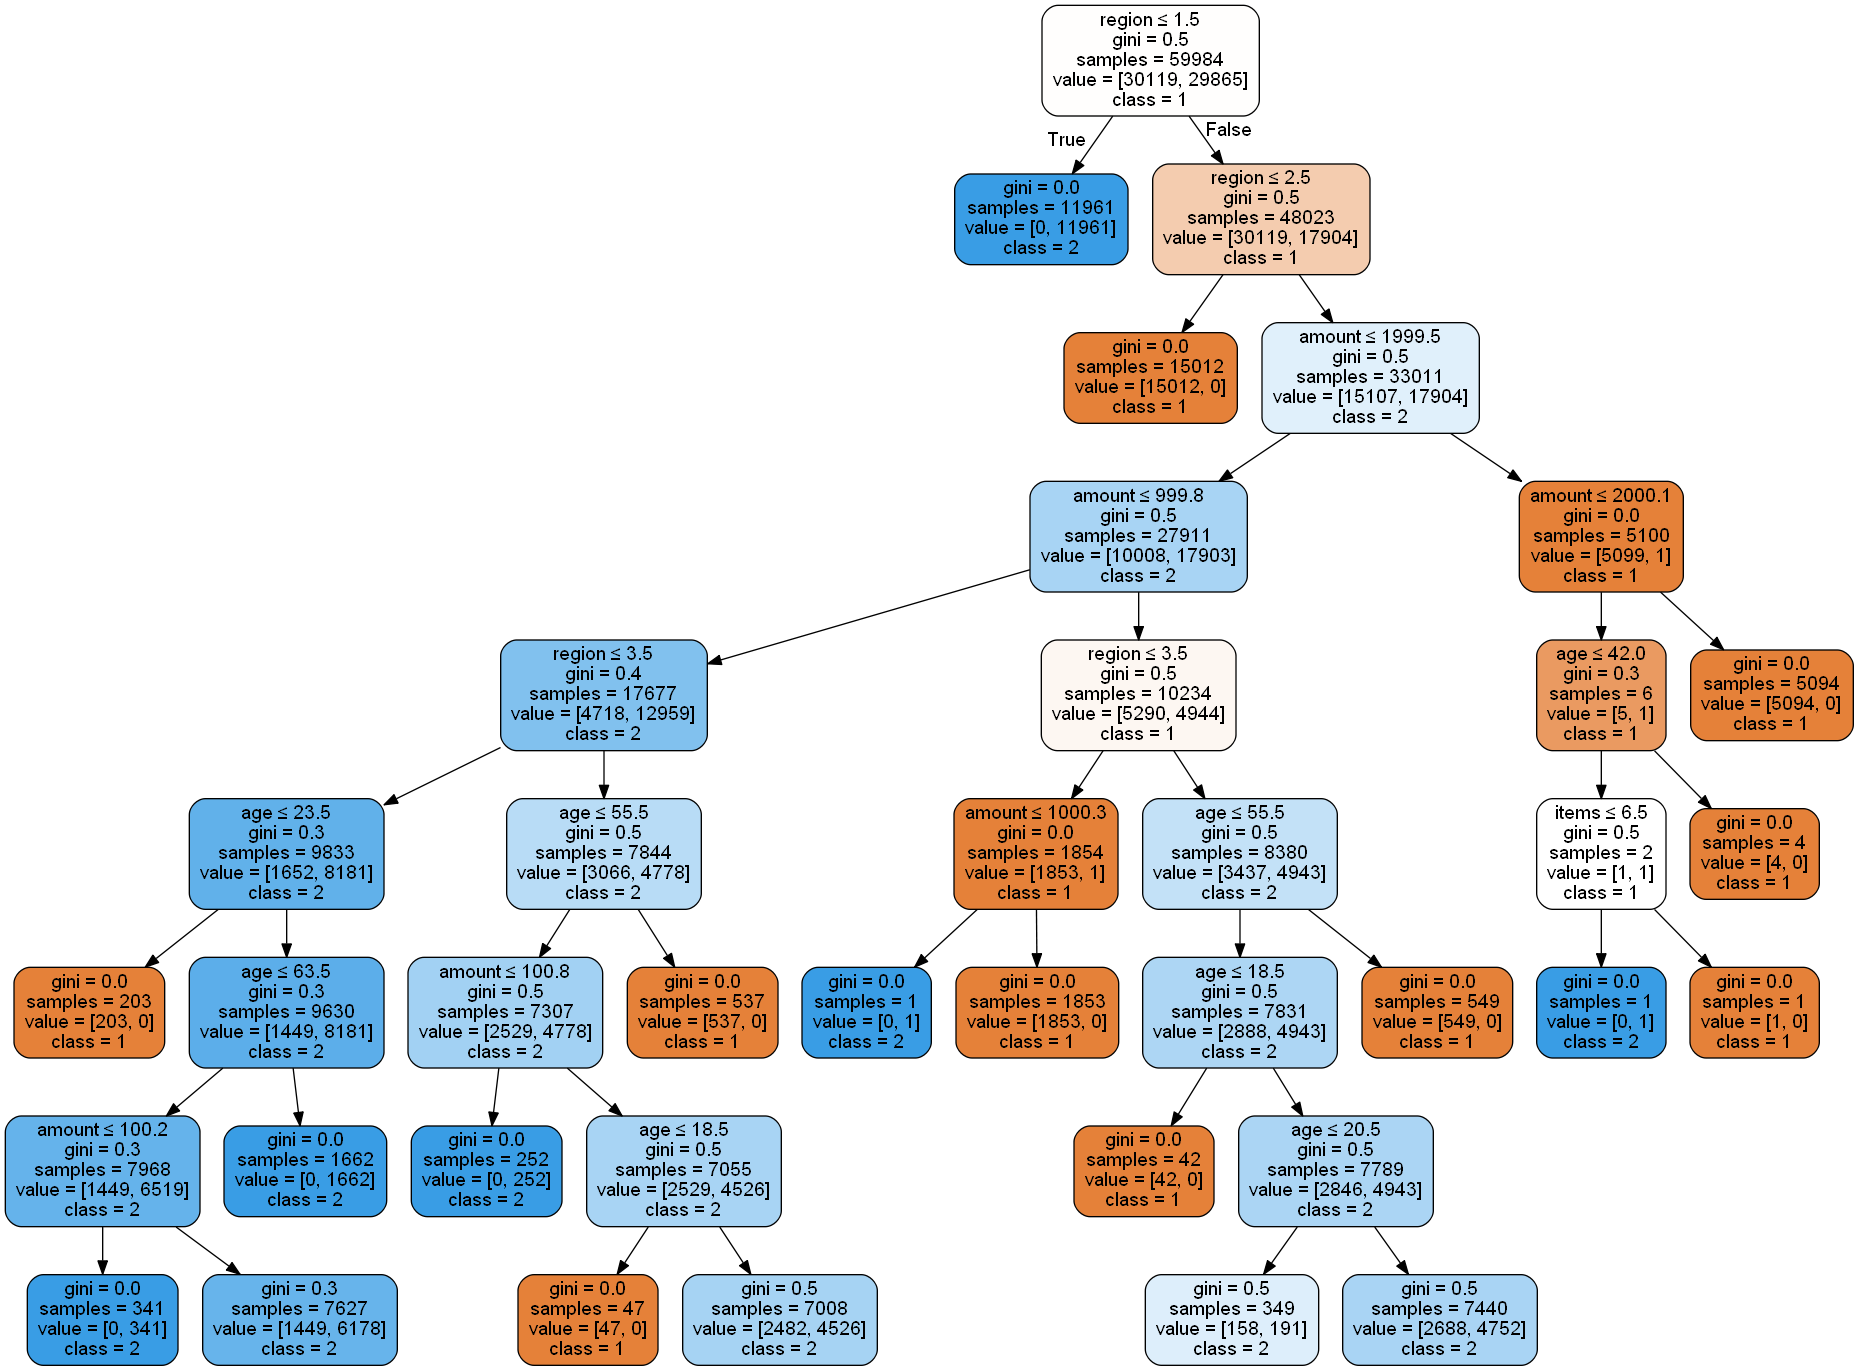

In [95]:
# Visualizing this Decision Tree Model
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
    filled=True, rounded=True,
    feature_names=X.columns,
    class_names=region_values, label='all', precision=1,
    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Class: 0 = Online, 1 = In-store

### Feature order = items, region, age, amount

In [96]:
# With 88% accuracy, we can predict 55 year old spending $670 on 6 items in region 1 will purchase in-store
model.predict([[6, 1, 55, 670]])

array([1], dtype=int64)

In [97]:
# 46 year old spending $1400 on 1 item in region 4 will purchase in-store
model.predict([[1, 4, 46, 1400]])

array([1], dtype=int64)

In [98]:
# 27 year old spending $2600 on 4 items in region 3 will purchase online
model.predict([[4, 3, 27, 2600]])

array([0], dtype=int64)

In [120]:
# Crosstable of Online (0) and In-store (1) transactions
pd.crosstab(index=data['region'], columns=data['in-store'])

in-store,0,1
region,,
1,0,15997
2,19994,0
3,7001,10999
4,12994,12994


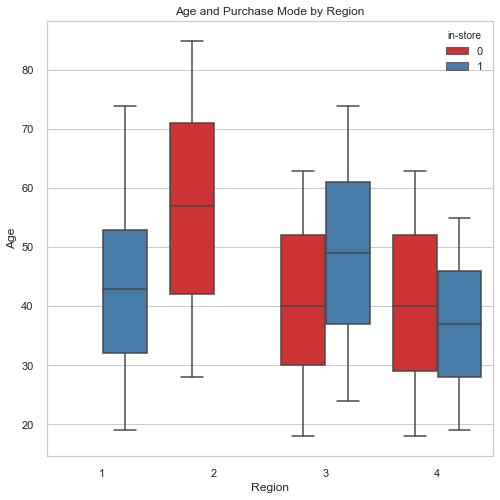

In [121]:
# Using Seaborn to visualize average age by purchase mode and region
sns.set_style('whitegrid') 
plt.figure(figsize=(8,8)) # Reset figure size proportionally
h = sns.boxplot(x='region', y='age', hue='in-store', data=data, palette='Set1')
plt.xlabel('Region')
plt.ylabel('Age')
plt.title('Age and Purchase Mode by Region')
plt.show(h)

In [101]:
# Average age by Online=0 or In-store=1
# Customers who purchase online are, on average, 5.5 years older than those who purchase in-store
sr = data.groupby(['in-store'])['age'].mean()
print(round(sr,2))

in-store
0    48.56
1    42.96
Name: age, dtype: float64


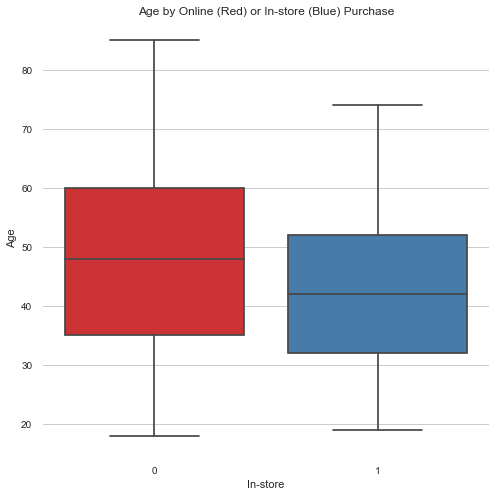

In [102]:
# Visualization of average age by Online=0 or In-store=1 purchasing
sns.set_style('whitegrid') 
plt.figure(figsize=(8,8)) # Reset figure size proportionally
h = sns.boxplot(x='in-store', y='age', data=data, palette='Set1')
plt.xlabel('In-store', )
plt.ylabel('Age')
plt.title('Age by Online (Red) or In-store (Blue) Purchase')
plt.show(h)

In [103]:
from cycler import cycler

### Is there any correlation between the age of a customer and if the transaction was made online or in-store?

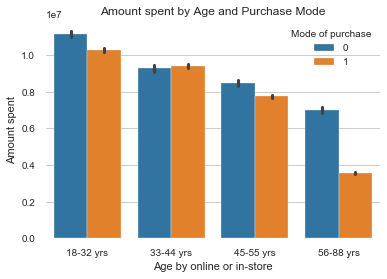

In [105]:
# Shows all age groups spend about equal amounts in-store and online, except older ages, who spend about double Online
ax = sns.barplot(x='age_cat_4', y='amount', hue='in-store', data=data, estimator=sum)
ax.set_xticklabels(['18-32 yrs', '33-44 yrs', '45-55 yrs', '56-88 yrs'])
plt.title('Amount spent by Age and Purchase Mode')
plt.xlabel('Age by online or in-store')
plt.ylabel('Amount spent')
plt.legend(title='Mode of purchase')
labels = ['Online', 'In-store']

### This graph shows that in the older age groups, people are more likely to purchase online. 
### Let's visualize 5 equal sized age bins to get more precise and see if it makes a difference in older age groups.

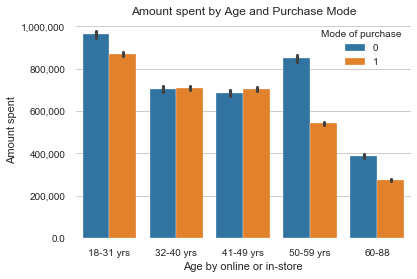

In [110]:
# Shows all age groups spend about equal amounts in-store and online, except older ages
ax = sns.barplot(x='age_cat_5', y='amount', hue='in-store', data=data, estimator=sum)
ax.set_xticklabels(['18-31 yrs', '32-40 yrs', '41-49 yrs', '50-59 yrs', '60-88'])
ax.set_yticklabels(['0.0','200,000','400,000','600,000','800,000','1,000,000'])
plt.title('Amount spent by Age and Purchase Mode')
plt.xlabel('Age by online or in-store')
plt.ylabel('Amount spent')
plt.legend(title='Mode of purchase')
labels = ['Online', 'In-store']

The above two graphs reveal that customers in the oldest age groups purchase online more, thus, age is a predictor in whether or not a sale will be made online or in-store.

### Do any other factors predict if a customer will buy online or in-store?

Text(0, 0.5, 'Average amount spent')

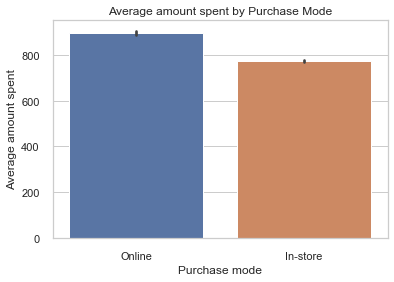

In [126]:
# Comparing average amount spent Online and In-store
ax = sns.barplot(x='in-store', y='amount', data=data)
ax.set_xticklabels(['Online', 'In-store'])
plt.title('Average amount spent by Purchase Mode')
plt.xlabel('Purchase mode')
plt.ylabel('Average amount spent')

The above graph shows that total online sales are slightly higher than in-store. This, combined with the very weak correlation between amount and in-store purchases (-0.0855) tells us that amount spent is a weak predictor of where a customer purchases.

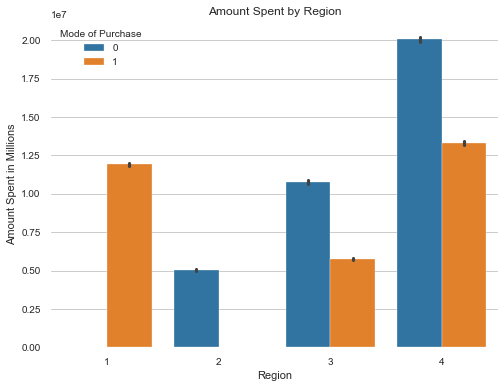

In [112]:
# Shows clear differences in Online and In-store purchasing by region
plt.figure(figsize=(8,6))
sns.barplot(x='region', y='amount', hue='in-store', data=data, estimator = sum)
plt.xlabel('Region')
plt.ylabel('Amount Spent in Millions')
plt.title('Amount Spent by Region')
plt.legend(title='Mode of Purchase')

The above graph shows region clearly helps predict whether or not a customer will purchase online or in-store.

Region 2 only purchases online (no stores).
Regions 3 and 4 spend almost double online than in-store.
Region 1 only purchases in-store (which doesn't seem plausible. Another continent? Non-existent marketing?)

In [127]:
# Total absolute sales by region and purchase mode
sr = data.groupby(['in-store', 'region'])['amount'].sum()
print(round(sr,2))

in-store  region
0         2          5040442.24
          3         10793540.39
          4         20058007.38
1         1         11917620.05
          3          5729913.08
          4         13308982.64
Name: amount, dtype: float64


### Management's hypothesis is that older age groups spend more on electronics than younger. Is this true? 

In [114]:
# Average amount spent by 10 equal-width age categories (0=youngest)
# Disproves Martin's hypothesis that older people spend more on electronics than younger people
aa = data.groupby(['age_cat'])['amount'].mean()
print(round(aa,2))

age_cat
0    1257.17
1     965.28
2     894.90
3     878.43
4     883.41
5     855.43
6     750.07
7     394.67
8     326.04
9     254.22
Name: amount, dtype: float64


The above chart shows average amount spent progressively decreases with age, disproving management's hypothesis that older customers spend more per transaction.

The following 3 graphs really help to visualize the outcome.

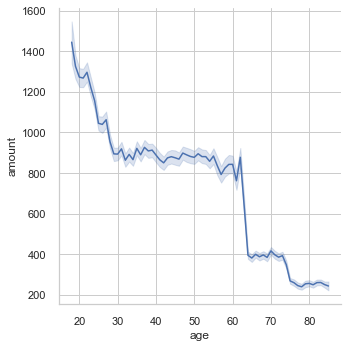

In [128]:
# Visualizing amount spent by age by seaborn line graph
sns.set(style='whitegrid')

amt_age = sns.relplot(x='age', y='amount', kind='line', data=data)

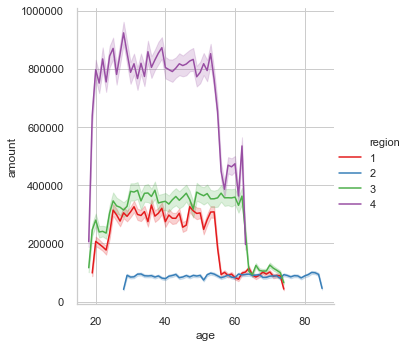

In [130]:
# Visualizing amount spent by age and region, this one reveals amount spent remains pretty steady from 20-55 yrs
sns.set(style='whitegrid')

am = sns.relplot(x='age', y='amount', hue='region',
                          kind='line', 
                          data=data, 
                          estimator=sum, 
                          palette='Set1')

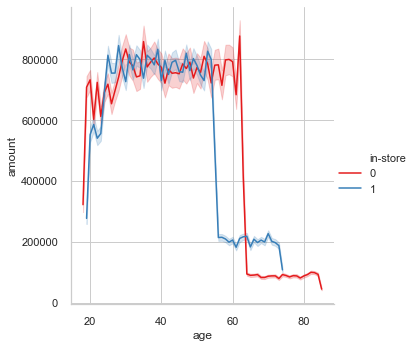

In [131]:
# Amount spent by age and Online (0) and In-store (1)
# Older adults still purchase, just spend less
sns.set(style='whitegrid')

am = sns.relplot(x='age', y='amount', hue='in-store',
                          kind='line', 
                          data=data, 
                          estimator=sum, 
                          palette='Set1')

In [183]:
import matplotlib.patches as mpatches

### The following bar plots show changes in amount spent by age groups and region

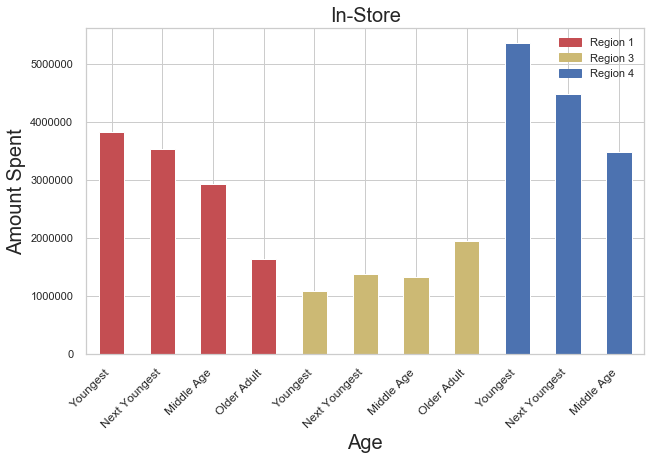

In [215]:
# In-store purchases grouped by region (1, 3, 4), age categories, and amount
df = data[data['in-store']==1].groupby(['region','age_cat_4'])['amount'].sum()

index = np.arange(11)
labels = ['Youngest','Next Youngest','Middle Age','Older Adult', 'Youngest','Next Youngest','Middle Age','Older Adult','Youngest','Next Youngest','Middle Age']

colors = ['r','y','b']
texts = ['Region 1','Region 3','Region 4']
patches = [mpatches.Patch(color=colors[i], label='{:s}'.format(texts[i])) for i in range(len(texts))]
plt.figure(figsize=(10,6))

bars = df.plot.bar(color=['r','r','r','r','y','y','y','y','b','b','b'])
plt.xlabel('Age', fontsize=20)
plt.ylabel('Amount Spent', fontsize=20)
plt.title('In-Store', fontsize=20)
plt.xticks(index, labels, rotation=45, fontsize=12, ha='right')
plt.legend(handles=patches)

The above bar plot shows In-Store sales by Age and Region. Region 3 is the only region in which In-Store spending increases with age. Spending declines with age in Regions 1 and 4.

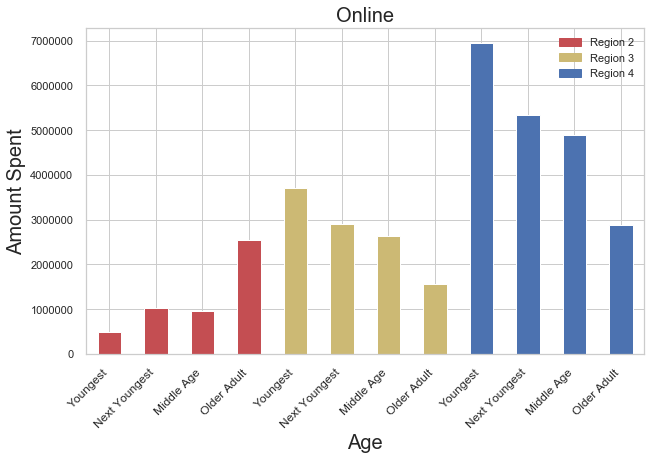

In [216]:
# Online purchases grouped by region (2, 3, 4), age categories, and amount
df = data[data['in-store']==0].groupby(['region','age_cat_4'])['amount'].sum()

index = np.arange(12)
labels = ['Youngest','Next Youngest','Middle Age','Older Adult', 'Youngest','Next Youngest','Middle Age','Older Adult','Youngest','Next Youngest','Middle Age', 'Older Adult']

colors = ['r','y','b']
texts = ['Region 2','Region 3','Region 4']
patches = [mpatches.Patch(color=colors[i], label='{:s}'.format(texts[i])) for i in range(len(texts))]
plt.figure(figsize=(10,6))

bars = df.plot.bar(color=['r','r','r','r','y','y','y','y','b','b','b','b'])
plt.xlabel('Age', fontsize=20)
plt.ylabel('Amount Spent', fontsize=20)
plt.title('Online', fontsize=20)
plt.xticks(index, labels, rotation=45, fontsize=12, ha='right')
plt.legend(handles=patches)

The above bar plot shows Online sales by Age and Region. Region 2 is the only region in which Online spending increases with age. Spending declines with age in Regions 3 and 4.